# Comparison of arrival direction and joint models

In order to verify the model is working, we fit simulations made under the assumptions of the model. We also compare the differences between a model for only the UHECR arrival directions and one for both the UHECR arrival directions and energies.
<br>
<br>
*This code is used to produce Figures 7 and 8 (left panel) in Capel & Mortlock (2019).*

In [1]:
import numpy as np
import h5py
from matplotlib import pyplot as plt
from pandas import DataFrame

# For testing
import sys
sys.path.append('../../../../fancy')

from fancy import Data, Model, Analysis, Results

/Users/fran/projects/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/fran/projects/bayes/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# Define location of Stan files
stan_path = '../../../stan/'

# Define file containing source catalogue information
source_file = '../../../data/sourcedata.h5'
table_file = '../../../data/integration_tables_50_SBG23.h5'

# Define output files
sim_output_file = 'output/joint_model_simulation.h5'
arrival_output_file = 'output/arrival_direction_fit.h5'
joint_output_file = 'output/joint_fit.h5'

# Define random seed to match paper results
random_seed_sim = 1992071502
random_seed_fit = 1992071502

## Simulation

Set up a simulation using randomly selected sources and the Pierre Auger Observatory as a detector. This simulation will include all the processes described in Section 2 of the paper. 

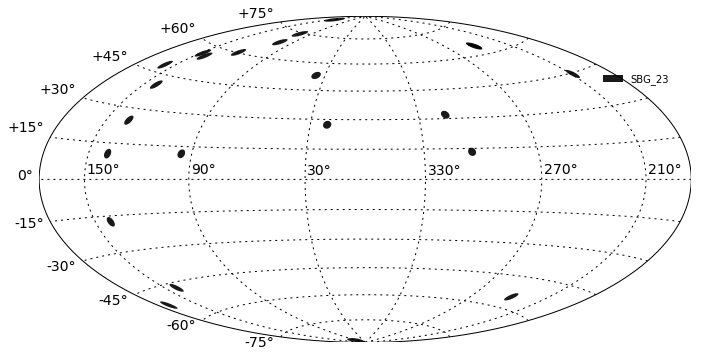

In [3]:
from fancy.detector.auger2014 import detector_properties, alpha_T, M

# Define a source catalogue and detector exposure
# In the paper we use the SBG catalogue
data = Data()
data.add_source(source_file, 'SBG_23')
data.add_detector(detector_properties)

# Plot the sources in Galactic coordinates
data.show();

In [4]:
# Define a Stan simulation to run
sim_name = stan_path + 'joint_model_sim.stan' # simulate all processes

# Define simulation using Model object and compile Stan code if necessary
simulation = Model(sim_filename = sim_name, include_paths = stan_path)
simulation.compile()

Using cached StanModel


In [5]:
from fancy.interfaces.stan import get_simulation_input

# Define associated fraction
f = 0.5 

# Simulation input
B = 20 # nG
alpha = 3.0
Eth = 52 # EeV
Eth_sim = 20 # EeV

Nsim = 2500 

# L in yr^-1, F in km^-2 yr^-1
L, F0 = get_simulation_input(Nsim, f, data.source.distance, M, alpha_T)

# To scale between definition of flux in simulations and fits
flux_scale = (Eth / Eth_sim)**(1 - alpha)

simulation.input(B = B, L = L, F0 = F0,
            alpha = alpha, Eth = Eth)

In [6]:
# What is happening 
summary = b'Simulation using the joint model and SBG catalogue' # must be a byte str
    
# Define an Analysis object to bring together Data and Model objects
sim_analysis = Analysis(data, simulation, analysis_type = 'joint', 
                    filename = sim_output_file, summary = summary)

In [7]:
# Build pre-computed values for the simulation as you go
# So that you can try out different parameters
sim_analysis.build_tables(sim_only = True)

In [8]:
# Run simulation
sim_analysis.simulate(seed = random_seed_sim, Eth_sim = Eth_sim)

# Save to file 
sim_analysis.save()

Running stan simulation...
Extracting output...
Simulating zenith angles...
Done!


### Visualise simulation results
Some simple functions are built in to allow quick visualisation of the simulation results. The arrival directions of the UHECRs are shown colour coded by the source component they come from, including the background component. The energy spectrum of the UHECRs is also shown, including the difference between $\tilde{E}$, $E$ and $\hat{E}$. 

In [ ]:
sim_analysis.plot('arrival direction')

In [ ]:
sim_analysis.plot('energy')

## Fit the arrival direction model

In [ ]:
# Define data from simulation
data = Data()
data.from_file(sim_output_file)
data.show();

In [ ]:
# Arrival direction model
model_name = stan_path + 'arrival_direction_model.stan'

# Compile
model = Model(model_filename = model_name, include_paths = stan_path)
model.compile()

# Define threshold energy in EeV
model.input(Eth = 52)

In [ ]:
# What is happening 
summary = b'Fit of the arrival direction model to the joint simulation' 
    
# Define an Analysis object to bring together Data and Model objects
analysis = Analysis(data, model, analysis_type = 'joint', 
                    filename = arrival_output_file, summary = summary)

In [ ]:
# Define location of pre-computed values used in fits 
# (see relevant notebook for how to make these files) 
# Each catalogue has a file of pre-computed values
analysis.use_tables(table_file)

In [ ]:
# Fit the Stan model
fit = analysis.fit_model(chains = 4, iterations = 2000, seed = random_seed_fit)

# Save to analysis file
analysis.save()

## Fit the joint model

This proceeds exactly as above, just changing the Stan model and output filename. 

In [21]:
data = Data()
data.from_file(sim_output_file)

model_name = stan_path + 'joint_model.stan'
model = Model(model_filename = model_name, include_paths = stan_path)
model.compile()
model.input(Eth = 52)

summary = b'Fit of the joint model to the joint simulation' 
analysis = Analysis(data, model, analysis_type = 'joint', 
                    filename = joint_output_file, summary = summary)
analysis.use_tables(table_file)

Using cached StanModel


In [22]:
fit = analysis.fit_model(chains = 4, iterations = 2000, seed = random_seed_fit)
analysis.save()
# NB: can ignore warnings for lambda, this is just a generated quantity and not a sampled parameter.

n_eff / iter looks reasonable for all parameters
Rhat for parameter lambda[8] is nan!
Rhat for parameter lambda[11] is nan!
Rhat for parameter lambda[69] is nan!
Rhat for parameter lambda[109] is nan!
Rhat for parameter lambda[128] is nan!
Rhat for parameter lambda[139] is nan!
Rhat for parameter lambda[150] is nan!
Rhat for parameter lambda[182] is nan!
  Rhat above 1.1 indicates that the chains very likely have not mixed
0.0 of 4000 iterations ended with a divergence (0.0%)
0 of 4000 iterations saturated the maximum tree depth of 10 (0.0%)
E-BFMI indicated no pathological behavior


# Figures

In [3]:
import seaborn as sns
from pandas import DataFrame

# to match paper
plt.style.use('minimalist') # FIX MARGINS
purple = '#592441'
grey = '#BEC1C2'

## Figure 7

Comparison of the joint and arrival direction fits.

In [24]:
# Get f samples for both models and true f value.
f_a = Results(arrival_output_file).get_chain(['f'])['f']
f_j = Results(joint_output_file).get_chain(['f'])['f']
f_true = Results(sim_output_file).get_truths(['f'])['f']

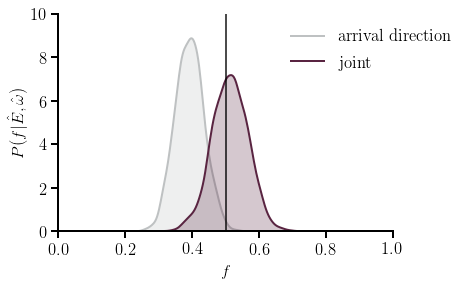

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches((6, 4))

sns.distplot(f_a, hist = False, 
             kde_kws = {'shade' : True, 'lw' : 2, 'zorder' : 0}, 
             color = grey, label = 'arrival direction')
sns.distplot(f_j, hist = False, 
             kde_kws = {'shade' : True, 'lw' : 2, 'zorder' : 1}, 
             color = purple, label = 'joint')
ax.axvline(f_true, 0, 10, color = 'k', zorder = 3, lw = 2., alpha = 0.7)

ax.set_xlim(0, 1)
ax.set_ylim(0, 10)
ax.set_xlabel('$f$')
ax.set_ylabel('$P(f | \hat{E}, \hat{\omega})$')
ax.legend(bbox_to_anchor = (0.65, 1.0));

## Figure 8 (left panel)

In [3]:
# Get chains from joint fit and truths from simulation
results_sim = Results(sim_output_file)
results_fit = Results(joint_output_file)

keys = ['F0', 'L', 'alpha', 'B', 'f']
chain = results_fit.get_chain(keys)

truth_keys = ['F0', 'L', 'alpha', 'B', 'f']
truth = results_sim.get_truths(truth_keys)
info_keys = ['Eth', 'Eth_sim']
info = results_sim.get_truths(info_keys)

# Correct for different Eth in sim and fit
# Also convert from Stan units to physical units
flux_scale = (info['Eth'] / info['Eth_sim'])**(1 - truth['alpha'])
truth['F0'] = truth['F0'] * flux_scale 
truth['L'] = truth['L'][0] * flux_scale /1.0e39 * 10

In [4]:
params = np.column_stack([chain[key] for key in keys])
truths = [truth[key] for key in keys]

# make nicely labelled dict
chain_for_df = {}
chain_for_df[r'$L$ / $10^{38}$ $\mathrm{yr}^{-1}$'] = chain['L'] * 10
chain_for_df[r'$F_0$ / $\mathrm{km}^{-2} \ \mathrm{sr} \ \mathrm{yr}^{-1}$'] = chain['F0'] / 1.0e3
chain_for_df[r'$B$ / $\mathrm{nG}$'] = chain['B']
chain_for_df[r'$\alpha$'] = chain['alpha']
chain_for_df[r'$f$'] = chain['f']

df = DataFrame(data = chain_for_df)
# order
df = df[[r'$F_0$ / $\mathrm{km}^{-2} \ \mathrm{sr} \ \mathrm{yr}^{-1}$', r'$L$ / $10^{38}$ $\mathrm{yr}^{-1}$', r'$\alpha$', r'$B$ / $\mathrm{nG}$', r'$f$']]

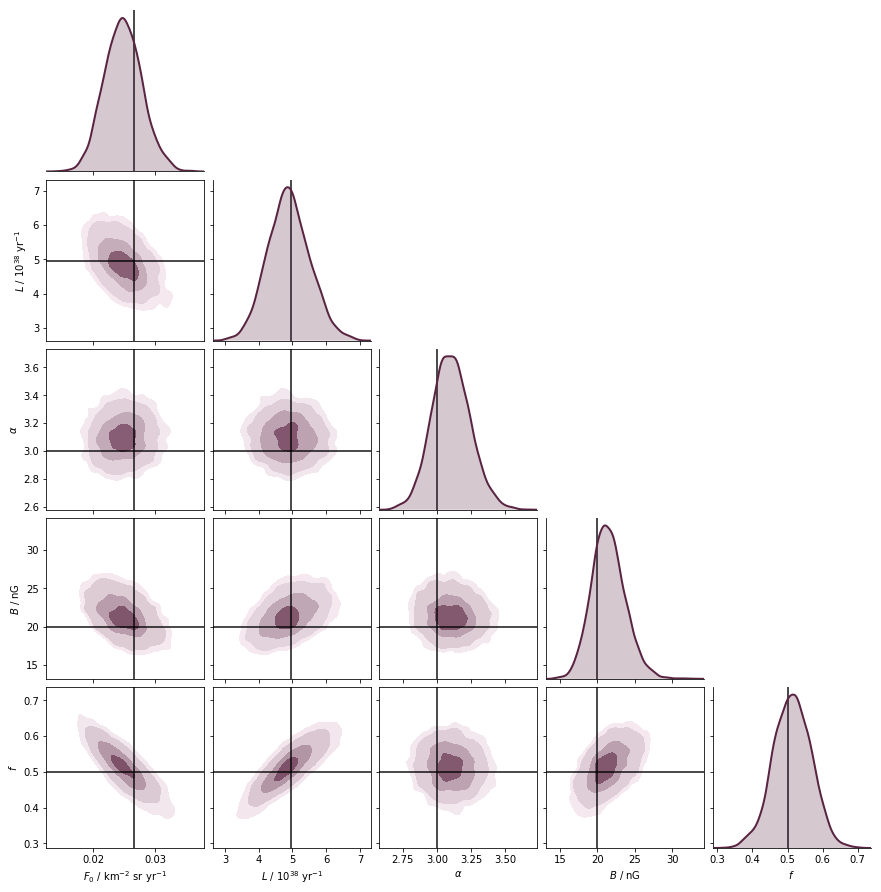

In [8]:
from fancy.plotting.corner import Corner

corner = Corner(df, truths) 